In [1]:
import pandas as pd
import json
from nltk import ngrams
import sys
import numpy as np
import itertools
import csv
import re
from scipy import sparse
from copy import copy, deepcopy
import time


In [72]:
datafile = "data/assignment3_aricles.json"

In [73]:
articles = pd.read_json(datafile, orient='records', encoding="utf-8")

In [74]:
articles.head()

,Content,Title,article_id
0,Tikcro enters into research and license agreem...,Tikcro enters into research and license agreem...,0
1,A North Carolina woman is trying to warn other...,Facebook Friend Request Nearly Cost One North ...,1
2,LONDON--(BUSINESS WIRE)--\n\nAMLIN plc\n\nTOTA...,Amlin plc UK Regulatory Announcement: Total Vo...,2
3,Khaleda asks for security\n\n\n\nBNP Chairpers...,Khaleda asks for security,3
4,Liberian Health Clinics Reopen Slowly with Ren...,Liberian Health Clinics Reopen Slowly with Ren...,4


In [89]:
#You can use n-gram at word level for this task
#try with different n-gram values 
# You can use ngrams from nltk for this

def GetShingels(articles, size):
    Shingle_DocId = []
    row = 0
    for docID in range(len(articles.Content)):
        row+=1
        print(row)
        shingles = []
        for i in range(len(articles.Content[docID])-(size-1)):
            shingles.append(articles.Content[docID][i:i+size])
            
        ShingleSet = set(shingles)
         
        for shingle in ShingleSet:
            Shingle_DocId.append([shingle, docID])
    
    return np.asarray(Shingle_DocId)

In [1]:
Shingle_DocId = GetShingels(articles, 2)

In [91]:
Shingle_DocId.shape

(17525672, 2)

## Convert n-grams into binary vector representation for each document. You can do some optimzations if the matrix is too big.
For example, 
* Select top 10000 most frequent n-grams.
* You may also try smaller values of n (like 2 or 3) which result in fewer n-grams.
* Finally, you can also try sparse matrix representation. Like csr_matrix from  scipy.sparse.

In [92]:
def getBinaryMatrix(articles, Shingle_DocId):

    DocID_array = []
    Shingle_array_index = []
    ShingleDataBase = {}
    unique_index = 0
        
    for shingle, DocId in Shingle_DocId:
        DocID_array.append(int(DocId))
        
        if shingle in ShingleDataBase:
            Shingle_array_index.append(ShingleDataBase[shingle])

        else:
            ShingleDataBase[shingle] = unique_index
            Shingle_array_index.append(ShingleDataBase[shingle])
            unique_index += 1


    row = np.asarray(Shingle_array_index)
    col = np.asarray(DocID_array)
    values = np.ones(len(Shingle_DocId))
    
    sparse_matrix = sparse.csc_matrix((values, (row, col)))
    
    return sparse_matrix


In [93]:
Sparse_matrix = getBinaryMatrix(articles, Shingle_DocId)

In [94]:
Sparse_matrix.shape

(14077, 48505)

In [95]:
Smatrix = Sparse_matrix.toarray()

## We need hash function that maps integers 0, 1, . . . , k − 1 to bucket numbers 0 through k − 1. It might be impossible to avoid collisions but as long as the collions are too many it won't matter much.

* The simplest would be using the builtin hash() function, it can be for example, hash(rownumber) % Numberofbuckets
* You can generate several of these hash functions by xoring a random integer (hash(rownumber)^randint) % Numberofbuckets
* It can also be a as simple as (rownumber * randint) % Numberofbuckets

In [96]:
#First determine the shape of our binary matrix
AmountOfShingles, NumOfDocs = Sparse_matrix.shape

In [97]:
# Generating hash functions by permuting
# This function generates the hash values. 
# Where every row speciefies the permutation of the rows in the binary matrix
numOfHashVal = 25

def GenerateHashValues(numOfHashVal, AmountOfShingles):
    h = np.empty([numOfHashVal, AmountOfShingles], dtype=int)
    for i in range (numOfHashVal):
        h[i] = np.random.permutation(AmountOfShingles)
    return h

HashValues = GenerateHashValues(numOfHashVal, AmountOfShingles)

In [98]:
HashValues.shape

(25, 14077)

## Compute minhash following the faster algorithm from the lecture 

In [2]:
# works fastest for now
def CreateSignatureMatrix (numOfHashVal, NumOfDocs, HashValues, matrix):
    SignatureMatrix = np.zeros((numOfHashVal, NumOfDocs))
    
    for i ,hashrow in enumerate(HashValues):
        start = time.time()
        print("Started the loop")
        for col in range(NumOfDocs): 
            #print("One col done")
            
            temp = np.array([])
            minimum = len(hashrow)
            for row in range(len(hashrow)):   
                if matrix[row, col]: 
                    if not hashrow[row]:
                        SignatureMatrix[i][col] = hashrow[row]
                        break
                    else:
                        if hashrow[row] < minimum:
                            minimum = hashrow[row]
                            SignatureMatrix[i][col] = hashrow[row] 
                            
        stop = time.time()
        print("The iteration took :", stop-start)
    
    return SignatureMatrix

SignatureMatrix = CreateSignatureMatrix(numOfHashVal, NumOfDocs, HashValues, Smatrix)

In [100]:
SignatureMatrix.shape

(25, 48505)

In [101]:
Signature = np.asarray(SignatureMatrix)

## Hash signature bands into buckets. Find a way to combine all the signature values in a band and hash them into a number of buckets ususally very high.
* Easiest way is to add all the signature values in the bucket and use a similar hash function like before

In [105]:
def LSH (Signature, numofhashfunc, NumOfdocs):
    
    rows, collums = Signature.shape
    
    bands = 5
    RowsPerBand = 5
    bucketsNum = 100000
    СandidatePairs = [[] for x in range (NumOfdocs)]
    
    for band in range (bands):
        buckets = [[] for x in range(bucketsNum)] 
        # Sum the signatures of each user in the band and use that as the bucket number   
        for DocId in range (NumOfdocs):
            SigSum = 0
            for row in range (RowsPerBand):
                SigSum += int(Signature[row + band * RowsPerBand][DocId])
            bucket = SigSum
            buckets[bucket].append(DocId)


        # For each bucket we check the similarities of all the pairs within that bucket
        for bucketId in range (bucketsNum):
            NumOfDocsInBucket = len(buckets[bucketId])  # checking amount of docids in a bucket
            if NumOfDocsInBucket > 1:
                for doc1, doc2 in itertools.combinations(buckets[bucketId], 2):

                    sig1 = Signature[:,doc1]
                    sig2 = Signature[:,doc2]
                    colisions = np.sum(sig1 == sig2)
                    similarity =  float(colisions)/(2 * numofhashfunc - colisions)
                    if similarity > 0.8:
                        СandidatePairs[doc1].append(doc2)
                        
    return СandidatePairs

                    
СandidatePairs = LSH(Signature, numOfHashVal, NumOfDocs)

## Tune parameters to make sure the threshold is appropriate.
## plot the probability of two similar items falling in same bucked for different threshold values

In [2]:
r = 5
b = 5

t = (1/b)**(1/r)
t

0.7247796636776955

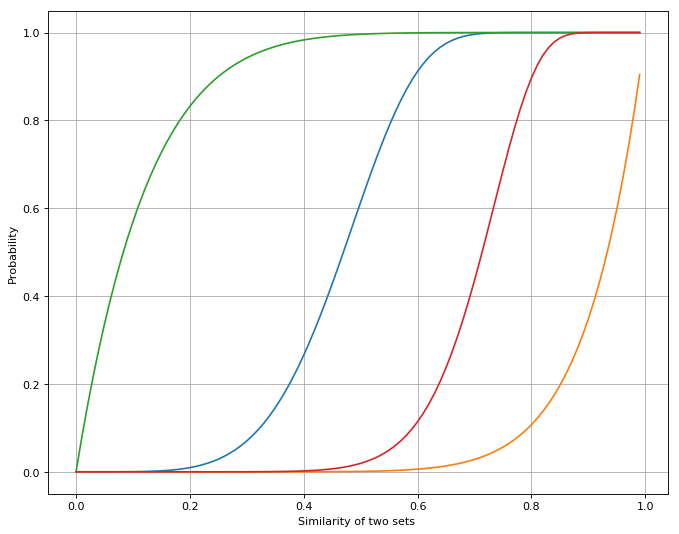

In [30]:
import matplotlib.pyplot as plt


prob = np.arange(0, 1, 0.01)
similarity1 = []
similarity2 = []
similarity3 = []
similarity4 = []

for x in prob:
    similarity1.append(1-(1-x**5)**30)  # r = 5, b = 30
    similarity2.append(1-(1-x**10)**1)  # r = 10, b = 11
    similarity3.append(1-(1-x**1)**8)  # r = 1, b = 8
    similarity4.append(1-(1-x**10)**20)  # r = 10, b = 20

fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
    
    
plt.plot(prob, similarity1)
plt.plot(prob, similarity2)
plt.plot(prob, similarity3)
plt.plot(prob, similarity4)

plt.xlabel('Similarity of two sets ')
plt.ylabel('Probability')
plt.grid(True)

plt.show()

## Write the nearest neibhors of each document to submissions.csv (comma separated, first column is the current document followed by a list of nearest neighbors) file and get the score

In [106]:
# Checking the real similarity and outputing the results

f1 = open('submissions.csv','w')
for i in range (len(СandidatePairs)):
    if len(СandidatePairs[i]) > 0:
        СandidatePairs[i] = list(set(СandidatePairs[i]))
        for j in СandidatePairs[i]:
            col1 = Signature[:,i].nonzero()
            col2 = Signature[:,j].nonzero()
            intersect = len(np.intersect1d(col1,col2))
            total = intersect + len(np.setxor1d(col1,col2))
            
            if total != 0:
                real_sim = intersect/total
                if real_sim > 0.9:
                    
                    f1.write(str(i) + "," + str(j) + "\n")
                    
f1.close()